# Molecular Isotopic Distributions Take 1: Permutations

Elements can have several [isotopes](https://en.wikipedia.org/wiki/Isotope), which have the same number of protons and electrons but different numbers of neutrons. Because a neutron has a mass of approximately 1 amu (atomic mass unit), different isotopes of an element appear at different mass-to-charge ratios in a mass spectrum as measured by a mass spectrometer.

Each element has a set of isotopes and associated natural abundances, meaning the percent of each isotope that is found in nature. For example, [oxygen has three stable isotopes](https://en.wikipedia.org/wiki/Isotopes_of_oxygen), <sup>16</sup>O with 99.8% natural abundance, <sup>17</sup>O with 0.0380% natural abundance, and <sup>18</sup>O with 0.205% natural abundance. [Chlorine has two stable isotopes](https://en.wikipedia.org/wiki/Isotopes_of_chlorine) with significant abundance: <sup>35</sup>Cl with 76% natural abundance and <sup>37</sup>Cl with 24% natural abundance. The distribution of isotopes thus forms a fingerprint for an element. 

When atoms combine into molecules, the mass distributions get richer. For example, in the diatomic molecule chlorine Cl<sub>2</sub>, there are three possible molecular isotopes considering the two chlorine atoms:

In [2]:
%%capture
!pip install rdkit
!pip install mendeleev
!pip install latexify-py

In [3]:
from collections import defaultdict
import hashlib
import json

from IPython.display import Markdown
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

import mendeleev
from rdkit import Chem
from rdkit.Chem import Descriptors
import latexify

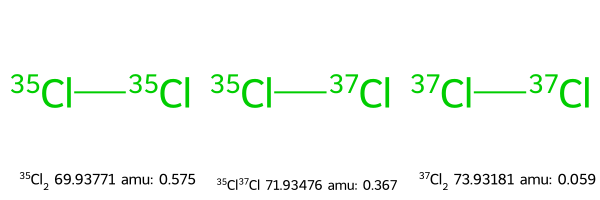

In [4]:
chlorine_smls = ["[35Cl][35Cl]", "[35Cl][37Cl]", "[37Cl][37Cl]"]
chlorine_mols = [Chem.MolFromSmiles(sml) for sml in chlorine_smls]
chlorine_masses = [Descriptors.ExactMolWt(mol) for mol in chlorine_mols]
chlorine_abundances = [0.574564, 0.366872, 0.058564]
formulas = [
    "<sup>35</sup>Cl<sub>2</sub>",
    "<sup>35</sup>Cl<sup>37</sup>Cl",
    "<sup>37</sup>Cl<sub>2</sub>",
]
legends = [
    f"{formula} {mass:.5f} amu: {abundance:.3f}"
    for formula, mass, abundance in zip(formulas, chlorine_masses, chlorine_abundances)
]
Chem.Draw.MolsToGridImage(chlorine_mols, legends=legends)

The molecule <sup>35</sup>Cl<sup>37</sup>Cl in the middle, with mixed isotopes, represents two possible placements of the isotopes: it is equivalent to <sup>37</sup>Cl<sup>35</sup>Cl because the order of the chlorine atoms is not significant due to symmetry. So while molecular structures are very helpful in many cases, here the formulas are better suited to our purpose of understanding the isotopic distributions.

The code to generate such molecules, masses, abundance, and images will be given in this blog post and the next.

In part 1, I use the naive method of creating a molecule for each possible arrangement of isotopes ([permutation](https://en.wikipedia.org/wiki/Permutation)) of a molecule. I hazily recalled that I could
- enumerate the [combinations](https://en.wikipedia.org/wiki/Combination), where the order of the isotopes over the atoms in a molecule is disregarded, and 
- calculate the permutations in each combination using the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) to calculate the number of arrangements of a given number of each isotope ([isotopomer](https://en.wikipedia.org/wiki/Isotopomer)),

but I decided to first try the approach that was easier to code.

## Set up

We use [sulfur dichloride, SCl<sub>2</sub>, a "cherry-red liquid"](https://en.wikipedia.org/wiki/Sulfur_dichloride) (inorganic chemistry is often colorful!), as the example molecule.

In [5]:
sml = "ClSCl"

Because RDKit excludes hydrogen atoms by default, but we want to assign isotopes to any hydrogen atoms that might be in our molecule, we tell RDKit to add hydrogens. This has no effect for sulfur dichloride.

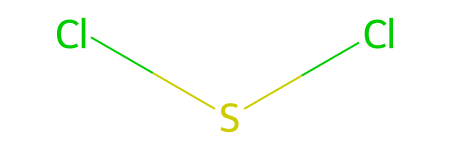

In [6]:
mol = Chem.AddHs(Chem.MolFromSmiles(sml))
mol

Next we define a `MolecularIsotope` class to store an RDKit molecule along with an abundance. If we didn't need to store the abundance, we could simply use RDKit mol and extract the exact mass.

Using an RDKit molecule is mostly a convenience: we could instead sum over the mass of the isotopic atoms, but it seemed easier to use a data structure to represent a molecule. Also, SMILES is a very common way of representing molecules, so it makes sense to start with SMILES, which the RDKit can transform into a molecule and then iterate through its atoms. 

In [7]:
class MolecularIsotope:
    """Store a molecule's isotopic properties."""

    def __init__(self, sml: str, mol: Chem.rdchem.Mol = None, abundance: float = None):
        self.sml = sml
        self.abundance = abundance
        if mol is not None:
            self.mol = mol
        else:
            try:
                self.mol = Chem.MolFromSmiles(sml)
            except:
                self.mol = Chem.MolFromSmiles(sml, sanitize=False)

    def update(self):
        """Define an update method so we can recalculate properties after the atoms' isotopes are set"""
        self.mass = Descriptors.ExactMolWt(self.mol)
        self.canon_sml = Chem.MolToSmiles(self.mol)

    def get_mass(self):
        """Get the exact mass"""
        return self.mass

Next we create a utility function to get the set of elements in a molecule.

In [8]:
def element_set(molecule: Chem.Mol) -> set[str]:
    """Get the set of elements in an RDKit molecule
    For example, ethanol (SMILES CCO, formula C2H5OH)
    returns {'C', 'O', 'H'}.

    :param molecule: An RDKit molecule
    :returns: A set of strings of element symbols
    """
    # Check that there is a valid molecule
    if molecule:
        # Add hydrogen atoms--RDKit excludes them by default
        molecule_with_Hs = Chem.AddHs(molecule)
        atom_symbols = set(atom.GetSymbol() for atom in molecule_with_Hs.GetAtoms())
        return atom_symbols

In [9]:
set_of_elements = element_set(mol)
set_of_elements

{'Cl', 'S'}

Now we can create a data structure to hold the isotopic abundances of each element in our molecule. The structure is a dictionary where the key is the element symbol and the value is a nested list of `[mass number, abundance]` pairs. We get the abundances from the [Mendeleev](https://pypi.org/project/mendeleev/) package, filtering to those isotopes whose abundance is not `None` to remove unstable isotopes, trace isotopes, etc.

In [10]:
isotopes = {}
for element_symbol in set_of_elements:
    element_isotopes = mendeleev.element(element_symbol).isotopes
    # Extract isotope mass number, and divide abundance by 100, for isotopes with significant abundance
    occurring_isotopes = [
        [isotope.mass_number, isotope.abundance / 100]
        for isotope in element_isotopes
        if isotope.abundance != None
    ]
    isotopes[element_symbol] = occurring_isotopes
print(isotopes)

{'Cl': [[35, 0.758], [37, 0.242]], 'S': [[32, 0.9484999999999999], [33, 0.0076300000000000005], [34, 0.04365], [36, 0.00015800000000000002]]}


In this approach, the isotope of each atom in the molecule will be set individually, so we'll create an `n`-dimensional NumPy array where `n` is the number of atoms. The length of each dimension is the number of isotopes for the element of that atom.

In [11]:
# Build iterable of number of isotopes by atom index
isotopes_by_atom_index = ()
for atom_index, atom in enumerate(mol.GetAtoms()):
    atom_symbol = atom.GetSymbol()
    isotopes_by_atom_index += (len(isotopes[atom_symbol]),)
isotopes_by_atom_index

(2, 4, 2)

Our initial array is empty, and we'll populate it with molecular isotope objects and set the isotopes next.

In [12]:
# Create the empty numpy ndarray with the shape of the number of isotopes for each atom
mol_isotopes = np.empty(isotopes_by_atom_index, dtype=object)
mol_isotopes

array([[[None, None],
        [None, None],
        [None, None],
        [None, None]],

       [[None, None],
        [None, None],
        [None, None],
        [None, None]]], dtype=object)

## Scale of the problem

To get a sense of the scale of the operation, let's calculate how many permutations ([isotopologues](https://en.wikipedia.org/wiki/Isotopologue)) we'll have to assign isotopes to.

In the NumPy array, there is a dimension for each atom (three) in the molecule, and the length of each dimension is the number of isotopes for the element of that atom (two for each Cl and four for the single S):

In [13]:
mol_isotopes.shape

(2, 4, 2)

We can calculate the number of elements by multiplying together the size of each dimensions:

In [14]:
size = 1
for dim_size in mol_isotopes.shape:
    size *= dim_size
size

16

or asking NumPy for the array size:

In [15]:
mol_isotopes.size

16

Using permutations is equivalent to painting balls in a line various colors, where the color represents the isotope, the ball represents an atom in the molecule, and we care about the order of the balls. This is a permutations with repetition scenario. We can verify that the size of the problem is correct using the formula for the number of [permutations with repetition](https://en.wikipedia.org/wiki/Permutation#Permutations_with_repetition):

In [16]:
@latexify.function
def permutations(n: int, r: int) -> int:
    """Calculate the number of permutations (with repetition, aka replacement) for a choice of n options for an object r times where order matters
    :param n: the number of options (for example, isotopes of an element) for an object
    :param r: the number of objects to choose
    :returns: the number of permutations
    """
    return n**r


permutations

where, for a given element, `n` is the number of isotopes and `r` is the number of atoms of that element. We used the nifty [latexify](https://github.com/google/latexify_py) package to automatically create a mathematical equation from the function code.

Each element's permutations can be calculated separately, then multiplied together to get the total for the molecule. For S, there are four isotopes and one atom, so four permutations:

In [17]:
p_S = permutations(4, 1)
p_S

4

For Cl, there are two isotopes and two atoms, so four permutations:

In [18]:
p_Cl = permutations(2, 2)
p_Cl

4

So for SCl<sub>2</sub> there are 16 permutations:

In [19]:
p_S * p_Cl

16

## Setting the isotope of each atom in each permutation

Now we come to the key operation: Setting the isotope of each atom in a molecule, for each permutation.

`set_isotopes` assigns isotopes to all elements in a multi-dimensional ndarray by
- recursively traversing down the ndarray until it comes to an individual element, not another (subordinate) ndarray
- inserting the `MolecularIsotope` object, including its RDKit molecule and the abundance
- for each atom,
    - assigning the isotope by referring to the `isotopes` array
    - assigning its abundance
    - calculating the overall abundance as the product of each of the atom's abundances
- calling the `MolecularIsotope.update()` method to set the exact mass

In [20]:
def set_isotopes(
    arr: np.ndarray[MolecularIsotope], sml: str, current_index: tuple
) -> np.ndarray[MolecularIsotope]:
    """Set the isotopes in an ndarray

    :param arr: the array or element of an array of Molecular isotope objects
    :param sml: the SMILES string of the molecule to put in the array
    :param current_index: the index of the current part (sub-array or element) of the array
    :returns: the array or element of an array, with atoms' isotopes set
    """
    if isinstance(arr, np.ndarray):
        # For an ndarray, iterate through its elements, recursively calling this function on them
        for i in range(len(arr)):
            arr[i] = set_isotopes(
                arr=arr[i], current_index=current_index + (i,), sml=sml
            )
        return arr
    else:
        # For an individual item in the ndarray, create a molecule
        item = MolecularIsotope(sml=sml)
        mol = item.mol
        abundance = 1

        # Iterate through the atoms in the molecule
        for atom_index, atom in enumerate(mol.GetAtoms()):
            # Check which element this atom is
            atom_symbol = atom.GetSymbol()

            # Determine which isotope-abundance pair to use
            isotope_data_to_use = isotopes[atom_symbol][current_index[atom_index]]

            # Get and set the isotope the atom
            isotope_to_use = isotope_data_to_use[0]
            atom.SetIsotope(isotope_to_use)

            # Calculate the molecule's abundance as the product of the abundance of each atom's isotope
            abundance *= isotope_data_to_use[1]
        item.update()
        # Set the MolecularIsotope's abundance property
        item.abundance = abundance
        return item

Let's set the isotope of each atom in the molecule for each permutation and verify that the array's shape is unchanged--we're just setting the properties of the `MolecularIsotope` objects.

In [21]:
mol_isotopes = set_isotopes(arr=mol_isotopes, sml=sml, current_index=())
mol_isotopes.shape

(2, 4, 2)

## Aggregating isotopomers

Because we created each permutation, we have to aggregate the isotopomers, analogous to matching up <sup>35</sup>Cl<sup>37</sup>Cl and <sup>37</sup>Cl<sup>35</sup>Cl.

It might be tempting to match molecules by mass, but a floating-point value can have some error or uncertainty. In some cases, the mass differences between different isotopologues can be quite small (for example less than 0.002 amu if the sum of the [mass numbers](https://en.wikipedia.org/wiki/Mass_number) is the same), so adding a numerical tolerance risks lumping distinct isotopologues together. So it's best to use a non-numerical identifier.

### Determining composition

In this case, we use the composition, which contains isotope labels. All we need is the number of each isotope of each element, so the SMILES string or molecular graph are not required. In particular, we
- use a nested dictionary where the first level key is the element e.g. Cl, and the second level is the isotope:count, for example 35:2 indicates that <sup>35</sup>Cl appears two times in the molecule
- convert to [JSON](https://en.wikipedia.org/wiki/JSON), sorting the keys to ensure a consistent order
- hash the result using `hash_nested_dict()`, below, to create a single string for comparison.

In [22]:
def composition(molecule: Chem.Mol, isotopes=False) -> dict[dict[int, int]]:
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, ethanol (SMILES [13C](H)(H)(H)CO, formula C2H6O) returns:
      if isotopes = False (default): {'C': 2, 'O': 1, 'H': 6}.
      if isotopes = True: {'C': {13: 1, 0: 1}, 'O': {0: 1}, 'H': {0: 6}}.

    :param molecule: The RDKit molecule to analyze
    :returns: if isotopes = False (default): a dictionary of element:count entries;
              if isotopes = True: a nested dictionary of element:isotope:count entries.
    """
    # Check that there is a valid molecule
    if molecule:
        # Add hydrogen atoms--RDKit excludes them by default
        molecule = Chem.AddHs(molecule)

        # Create a default dictionary so we can add counts for elements without having to explicitly add the element as a key
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule.GetAtoms():
            element_symbol = atom.GetSymbol()
            # If isotopes not requested, simply count the number of atoms of each element
            if not isotopes:
                comp[element_symbol] += 1
            # If isotopes requested, count the number of each isotope of each element
            else:
                isotope = atom.GetIsotope()
                try:
                    comp[element_symbol][isotope] += 1
                except:
                    comp[element_symbol] = defaultdict(lambda: 0)
                    comp[element_symbol][isotope] += 1
        return comp

Let's calculate the composition for our original molecule SCl<sub>2</sub>. The isotopes of its atoms are not set there, so they have a value of zero by RDKit's convention.

In [23]:
composition(mol, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'Cl': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 2}),
             'S': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 1})})

To make it easier to compare isotopic variations, we'll flatten the ndarray (whose dimension count is the number of atoms) using a utility function `flatten_ndarray`.

In [24]:
def flatten_ndarray(arr: np.ndarray) -> list:
    """Flatten an ndarray to a single dimension

    :param arr: the array or element of an array
    :returns: a one-dimensional list with all the elements from the ndarray
    """
    flat_list = []
    for element in arr:
        if isinstance(element, np.ndarray):
            flat_list.extend(flatten_ndarray(element))
        else:
            flat_list.append(element)
    return flat_list

We then flatten our `MolecularIsotope` ndarray and sort it by mass.

In [25]:
mol_isotopes_flat = flatten_ndarray(mol_isotopes)
mol_isotopes_flat.sort(key=lambda x: x.mass)

Here's the composition dictionary for the lightest (lowest-mass) isotopologue of our molecule:

In [26]:
example_composition = composition(mol_isotopes_flat[0].mol, isotopes=True)
example_composition

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'Cl': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {35: 2}),
             'S': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {32: 1})})

To check if two composition dictionaries are the same, we hash the dictionaries to boil all the contents of a dictionary down to a single string.

In [27]:
def hash_nested_dict(d: dict) -> str:
    """Hash a dictionary that's nested or not

    :param d: the dictionary
    :returns: the hash string
    """
    # Convert the nested dictionary to a JSON string with sorted keys
    json_str = json.dumps(d, sort_keys=True)

    # Hash the JSON string using the cryptographic hash function SHA-256
    hash_obj = hashlib.sha256()
    hash_obj.update(json_str.encode())
    return hash_obj.hexdigest()

Here's the hash for an example isotopologue:

In [28]:
hash_nested_dict(example_composition)

'58b343d486a33b5af66af84258a805aaf19df8b9f6279836a373e2c650ad26a4'

We use functions from previous posts to [create molecular formulas]({% post_url 2023-10-20-Molecular-Formula-Generation %}) and [present the molecular formulas in a Markdown table](({% post_url 2023-10-28-Display-Molecular-Formulas %})).

In [29]:
def mol_to_formatted_formula(
    mol: Chem.Mol,
    isotopes: bool = False,
) -> dict[str, str]:
    """Convert an RDKit molecule to a formatted formula, in Markdown and LaTeX

    :param mol: RDKit molecule
    :param isotopes: Whether to consider isotopes
    :returns: a dictionary of format:string pairs, e.g. {"markdown":"markdown_string", "latex":"latex_string"}
    """
    if mol is None:
        return "Invalid molecule"
    comp = composition(mol, isotopes)

    formula = {"markdown": "", "latex": ""}

    if isotopes:
        # If isotopes are requested
        isotopes_dict = defaultdict(lambda: defaultdict(str))
        subscripts = defaultdict(lambda: defaultdict(int))
        superscripts = defaultdict(list)

        for element, counts in comp.items():
            for isotope, count in counts.items():
                if count > 1:
                    subscripts[element][isotope] = count
                if isotope != 0:
                    superscripts[element].append(isotope)

                isotopes_dict[element][isotope] = 1
            # Sort the element's isotopes from lowest to highest
            superscripts[element].sort()

        last_item_is_subscript = False
        sorted_element_keys = sorted(isotopes_dict.keys())
        for element in sorted_element_keys:
            isotope_count_pairs = isotopes_dict[element]
            # Sort the element's isotopes from lowest to highest
            sorted_isotope_keys = sorted(isotope_count_pairs.keys())
            for isotope in sorted_isotope_keys:
                if element in superscripts:
                    if isotope in superscripts[element]:
                        formula["markdown"] += f"<sup>{isotope}</sup>"

                        # If superscript immediately follows subscript,
                        # add a small amount of horizontal space using an empty group {}
                        # to prevent them from vertically overlapping
                        if last_item_is_subscript:
                            formula["latex"] += "{}"
                        formula["latex"] += "^{ %d}" % isotope
                        last_item_is_subscript = False
                formula["markdown"] += element
                formula["latex"] += element
                last_item_is_subscript = False
                if element in subscripts:
                    if isotope in subscripts[element]:
                        isotope_count = subscripts[element][isotope]
                        formula["markdown"] += f"<sub>{isotope_count}</sub>"
                        formula["latex"] += "_{ %d}" % isotope_count
                    last_item_is_subscript = True
        # Add beginning and ending dollar signs to LaTeX formula
        formula["latex"] = "$" + formula["latex"] + "$"
    else:
        # Handling the case when isotopes is False
        sorted_element_keys = sorted(comp.keys())

        for element in sorted_element_keys:
            count = comp[element]
            formula["markdown"] += element
            formula["latex"] += element
            if count > 1:
                formula["markdown"] += f"<sub>{count}</sub>"
                formula["latex"] += "_{ %d}" % count
        formula["latex"] = "$" + formula["latex"] + "$"

    return formula

In [30]:
def dict_list_to_markdown_table(data: list, number_rows: bool = False) -> str:
    """
    Convert a list of dictionaries into a Markdown table.

    :param data: A list of dictionaries, where each dictionary corresponds to a row in the table.
    :param include_row_numbers: Whether to include a row number column.
    :returns: The Markdown-formatted table as a string.
    """
    if not data:
        return ""

    # Extract column headers from the keys of the first dictionary
    headers = data[0].keys()

    # If include_row_numbers is True, add the "Row #" column
    if number_rows:
        headers = ["#"] + list(headers)

    # Create the table headers
    table = "| " + " | ".join(headers) + " |\n"

    # Create the title divider line
    table += "|"
    for _ in headers:
        table += " --- |"
    table += "\n"

    # Create the table body
    for i, row in enumerate(data):
        if number_rows:
            row_data = [i + 1] + [row.get(header, "") for header in headers[1:]]
        else:
            row_data = [row.get(header, "") for header in headers]

        table += "| " + " | ".join(map(str, row_data)) + " |\n"

    return table

### Putting isotologues in a dataframe

Now we prepare the data to put into a Polars dataframe. We use Polars because it's easy to aggregate based on matching a value such as composition, and very fast. We extract all properties of the MolecularIsotope, most importantly its abundance. We use `hash_nested_dict()` to prepare the string for comparison for aggregation of isotopomers.

In [31]:
# Create a list of dictionaries, where each item in the list is a MolecularIsotope
data_dict_list = []
for mol_isotope in mol_isotopes_flat:
    # Update the mass and canonical SMILES
    mol_isotope.update()

    # Extract each property of the MolecularIsotope into a dictionary
    data_dict = {prop: getattr(mol_isotope, prop) for prop in vars(mol_isotope).keys()}

    # Add the MolecularIsotope object itself as a dictionary entry
    data_dict["mol_isotope"] = mol_isotope

    # Determine and hash the composition dictionary
    composition_dict = composition(mol_isotope.mol, isotopes=True)
    hashed_composition_dict = hash_nested_dict(composition_dict)
    data_dict["composition_hash"] = str(hashed_composition_dict)

    # Add the current MolecularIsotope's dictionary to the list of MolecularIsotopes
    data_dict_list.append(data_dict)

# Create a Polars dataframe
df = pl.DataFrame(data_dict_list).select(
    ["mass", "abundance", "composition_hash", "mol"]
)

max_abundance = df["abundance"].max()

# Add the Markdown formula and relative abundance for each MolecularIsotope
df = df.with_columns(
    pl.col("mol")
    .map_elements(lambda x: mol_to_formatted_formula(x, isotopes=True)["markdown"])
    .alias("formula"),
)

# Select human-readable columns to present
df_display = df.select(["mass", "formula", "abundance", "composition_hash"]).sort(
    "mass"
)

# Create Markdown table
table_permutations = dict_list_to_markdown_table(
    df_display.rows(named=True),
    number_rows=True,
)
# Present the data as a Markdown table
Markdown(table_permutations)

| # | mass | formula | abundance | composition_hash |
| --- | --- | --- | --- | --- |
| 1 | 101.90977636 | <sup>35</sup>Cl<sub>2</sub><sup>32</sup>S | 0.5449739539999999 | 58b343d486a33b5af66af84258a805aaf19df8b9f6279836a373e2c650ad26a4 |
| 2 | 102.90916411999999 | <sup>35</sup>Cl<sub>2</sub><sup>33</sup>S | 0.00438392332 | 5003158917865e69ae25cd83608f6b6c90bf72b5ee0a0ec2ef922c0b2c9aceae |
| 3 | 103.90557225999999 | <sup>35</sup>Cl<sub>2</sub><sup>34</sup>S | 0.025079718600000002 | e558fc61ef18a5650f1c98ab256cd479af332e576da13e473da3e4e97a12a07a |
| 4 | 103.90682627 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>32</sup>S | 0.17398904599999998 | 444f93bbf68bd8975511aaaf45c4be7d154b7a3e41981e452590409bbe703aa4 |
| 5 | 103.90682627 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>32</sup>S | 0.17398904599999998 | 444f93bbf68bd8975511aaaf45c4be7d154b7a3e41981e452590409bbe703aa4 |
| 6 | 104.90621402999999 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>33</sup>S | 0.0013996166800000001 | 88a81501d027e6b3919ac9343f1b9ddb6c2422b2a0e2926a85dca933fed0a1b1 |
| 7 | 104.90621403 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>33</sup>S | 0.0013996166800000001 | 88a81501d027e6b3919ac9343f1b9ddb6c2422b2a0e2926a85dca933fed0a1b1 |
| 8 | 105.90262216999999 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>34</sup>S | 0.0080069814 | 64ff7f3b937033a6db02ef0985823fe636bba3ce5a9c65f459967815a0c70bd6 |
| 9 | 105.90262217 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>34</sup>S | 0.0080069814 | 64ff7f3b937033a6db02ef0985823fe636bba3ce5a9c65f459967815a0c70bd6 |
| 10 | 105.90387618 | <sup>37</sup>Cl<sub>2</sub><sup>32</sup>S | 0.05554795399999999 | 2846a5aed0b61cb6e6c1bde01b2051da891b5c06290115bcff811d5d04435247 |
| 11 | 105.90478612 | <sup>35</sup>Cl<sub>2</sub><sup>36</sup>S | 9.078111200000001e-05 | 35d4df87f08f6ec8b521d6f545787b659991b496b227a03b94e4ff8157a66bd8 |
| 12 | 106.90326394 | <sup>37</sup>Cl<sub>2</sub><sup>33</sup>S | 0.00044684332 | 1c5cefe1901b9c7f439341aa00b449b1d198e13afbb534bee49de13d0ddf77af |
| 13 | 107.89967208 | <sup>37</sup>Cl<sub>2</sub><sup>34</sup>S | 0.0025563186 | a130fb6a86bc81832b58683b416af62f0c16c1ddd4030dfdabb5650d34281525 |
| 14 | 107.90183603 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>36</sup>S | 2.8982888000000004e-05 | fee991b6b30e80e33e2e3bcf8432db6d0a7882770361bd2c3a34e344ceceee99 |
| 15 | 107.90183603 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>36</sup>S | 2.8982888000000004e-05 | fee991b6b30e80e33e2e3bcf8432db6d0a7882770361bd2c3a34e344ceceee99 |
| 16 | 109.89888594 | <sup>37</sup>Cl<sub>2</sub><sup>36</sup>S | 9.253112e-06 | 65289ce387b1115696a2b72164a4c940e3fa1c8218a35fa89eb702edd6d3d1c5 |


The table confirms our earlier calculation that are a total of 16 permutations. Again, the number of permutations is the product of the number of isotopes over each atom in SCl<sub>2</sub>. In this case each of the two Cl atoms has two isotopes, while the one S atom has four isotopes, so 2 * 2 * 4 = 16.

### Aggregating rows in a dataframe

The following aggregation expressions tell Polars to sum over abundance, and take the first value for other columns (besides the composition, which we're aggregating on). This is easier and faster than writing Python code to aggregate isotopomers.

In [32]:
# Set up aggregation expressions
agg_exprs = [pl.sum("abundance").alias("abundance")] + [
    pl.col(col).first().alias(col)
    for col in df.columns
    if col not in ("composition_hash", "abundance")
]

# Aggregate rows
agg_df = df.group_by("composition_hash").agg(agg_exprs)

We then add columns for formulas. We also calculate relative abundance, where the most abundant molecular isotope equals 1, for easy comparisons to mass spectrometry data which can likewise be easily normalized.

In [33]:
agg_df = agg_df.with_columns(
    # Compute formulas to display in Markdown table and on graph
    pl.col("mol")
    .map_elements(lambda x: mol_to_formatted_formula(x, isotopes=True)["markdown"])
    .alias("formula"),
    pl.col("mol")
    .map_elements(lambda x: mol_to_formatted_formula(x, isotopes=True)["latex"])
    .alias("formula_latex"),
    # Calculate relative abundance
    (pl.col("abundance") / max_abundance).alias("relative abundance"),
)

# Choose rows to display in Markdown table, and sort by mass
agg_df_display = agg_df.select(
    ["mass", "formula", "abundance", "relative abundance"]
).sort("mass")

# Create Markdown table
table = dict_list_to_markdown_table(agg_df_display.rows(named=True), number_rows=True)

# Display Markdown table
Markdown(table)

| # | mass | formula | abundance | relative abundance |
| --- | --- | --- | --- | --- |
| 1 | 101.90977636 | <sup>35</sup>Cl<sub>2</sub><sup>32</sup>S | 0.5449739539999999 | 1.0 |
| 2 | 102.90916411999999 | <sup>35</sup>Cl<sub>2</sub><sup>33</sup>S | 0.00438392332 | 0.00804428044280443 |
| 3 | 103.90557225999999 | <sup>35</sup>Cl<sub>2</sub><sup>34</sup>S | 0.025079718600000002 | 0.04602003162888773 |
| 4 | 103.90682627 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>32</sup>S | 0.34797809199999996 | 0.6385224274406333 |
| 5 | 104.90621402999999 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>33</sup>S | 0.0027992333600000002 | 0.0051364534753526965 |
| 6 | 105.90262216999999 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>34</sup>S | 0.0160139628 | 0.02938482230657211 |
| 7 | 105.90387618 | <sup>37</sup>Cl<sub>2</sub><sup>32</sup>S | 0.05554795399999999 | 0.10192772258616968 |
| 8 | 105.90478612 | <sup>35</sup>Cl<sub>2</sub><sup>36</sup>S | 9.078111200000001e-05 | 0.00016657880864522935 |
| 9 | 106.90326394 | <sup>37</sup>Cl<sub>2</sub><sup>33</sup>S | 0.00044684332 | 0.0008199351853795202 |
| 10 | 107.89967208 | <sup>37</sup>Cl<sub>2</sub><sup>34</sup>S | 0.0025563186 | 0.004690717017276022 |
| 11 | 107.90183603 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>36</sup>S | 5.796577600000001e-05 | 0.00010636430525632059 |
| 12 | 109.89888594 | <sup>37</sup>Cl<sub>2</sub><sup>36</sup>S | 9.253112e-06 | 1.697899859632558e-05 |


Compared to 16 permutations, the aggregated result has 12 distinct isotopomers (combinations). We'll understand why in the next blog post.

### Checking our abundances

To verify that we calculated and aggregated abundances correctly, we check that the sum of abundances of the isotopomers is 1. (It might be very slightly different depending on the isotope data, numerical precision of operations, etc.)

In [34]:
mol_isotopes_agg_abundances = agg_df["abundance"].to_list()
abundance_sum = sum(mol_isotopes_agg_abundances)
print(abundance_sum)

0.999938


## Plot abundance vs. mass results

A graph of abundance against mass simulates a mass spectrum. To prevent a forest of short lines and colliding labels due to the many isotopomers with very low abundance, we might want to limit the plot to a cutoff level of abundance.

In [35]:
cutoff = 0.05

# Filter the dataframe to abundances above the cutoff
agg_df_cutoff = agg_df.filter(pl.col("abundance") > cutoff)

# Format as Markdown table
df_display_cutoff = agg_df_cutoff.select(
    ["formula", "mass", "abundance", "relative abundance"]
).sort("mass")
table_cutoff = dict_list_to_markdown_table(
    df_display_cutoff.rows(named=True), number_rows=True
)
Markdown(table_cutoff)

| # | formula | mass | abundance | relative abundance |
| --- | --- | --- | --- | --- |
| 1 | <sup>35</sup>Cl<sub>2</sub><sup>32</sup>S | 101.90977636 | 0.5449739539999999 | 1.0 |
| 2 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>32</sup>S | 103.90682627 | 0.34797809199999996 | 0.6385224274406333 |
| 3 | <sup>37</sup>Cl<sub>2</sub><sup>32</sup>S | 105.90387618 | 0.05554795399999999 | 0.10192772258616968 |


These results are in fairly good agreement with those calculated with two [online](https://mstools.epfl.ch/info/) molecular isotope abundance [tools](https://www.sisweb.com/mstools/isotope.htm). Small differences between tools are likely due to differences in the values of natural abundances used (we used values from the [Mendeleev package](https://pypi.org/project/mendeleev/)), or perhaps computational methods such as approximations.

Now we can plot the isotopomers above that cutoff level of abundance. To display Markdown-formatted molecular formulas on the graph, we avoid conflicts with using {braces} for both LaTeX versus [f-strings](https://realpython.com/python-f-strings/) or [`{}.format()`](https://realpython.com/python-f-strings/#the-strformat-method) by resorting to [C-style string formatting with the % operator](https://realpython.com/lessons/old-school-string-formatting-python/).

Cl_{ 2}S


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


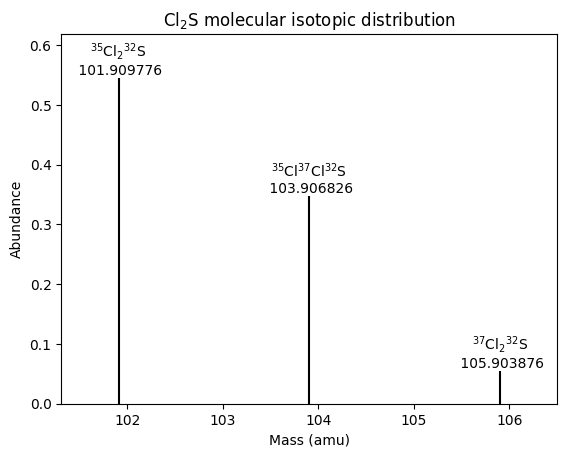

In [40]:
# Create the scatter plot using Seaborn; don't use markers because we'll plot lines instead
sns.scatterplot(x="mass", y="abundance", data=agg_df_cutoff, marker="")

plt.xlabel("Mass (amu)")
plt.ylabel("Abundance")

formula = mol_to_formatted_formula(mol)["latex"].strip("$")

# Use C-style string formatting with the % operator to avoid conflicts with using braces
title = r"${\rm %s}$ molecular isotopic distribution" % formula
plt.title(title)

# Adjust x-axis limits to allow more space on the left and right for labels
xrange = max(agg_df_cutoff["mass"]) - min(agg_df_cutoff["mass"])
xpad = xrange * 0.15
plt.xlim(min(agg_df_cutoff["mass"]) - xpad, max(agg_df_cutoff["mass"]) + xpad)

# Adjust y-axis limits to start at zero and allow more space on the top for labels
yrange = max(agg_df_cutoff["abundance"]) - min(agg_df_cutoff["abundance"])
ypad = yrange * 0.15
plt.ylim(0, max(agg_df_cutoff["abundance"]) + ypad)

# Iterate through the rows (data points)
for index, (mass, abundance, formula) in enumerate(
    zip(
        agg_df_cutoff["mass"],
        agg_df_cutoff["abundance"],
        agg_df_cutoff["formula_latex"],
    )
):
    # Add vertical lines from each data point to the x-axis
    plt.vlines(x=mass, ymin=0, ymax=abundance, colors="black")

    # Label the data points by mass
    label = r"${\rm %s}$ %s %s" % (formula.strip("$"), "\n", round(mass, 6))
    plt.text(x=mass, y=abundance, s=label, ha="center", va="bottom")

plt.show()

## Conclusion

Using permutations worked fine for this triatomic molecule. However, that it is computationally infeasible for large molecules: for example, assigning isotopes for all permutations of napthlene, C<sub>10</sub>H<sub>8</sub> (SMILES of `c1c2ccccc2ccc1`), where each element has two isotopes and there are thus [2<sup>18</sup> = 262,144 permutations](https://en.wikipedia.org/wiki/Power_of_two#Table_of_values), took about 170 seconds. So in part 2 I'll share a more sophisticated and tractable approach using combinations.

*Acknowledgement: I thank my late father [Robert Monat](https://www.arnmortuary.com/obituary/Robert-Monat) for teaching me about combinations vs. permutations.*